In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential , Model

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,classification_report

import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import keras

tf.random.set_seed(42)

print('TF Version:', tf.__version__)

TF Version: 2.16.1


In [12]:
%%capture
# download the images and unzip
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1CtOsyMzWr8jyQIwkiPULkdMUPgTR19a-
!unzip -q hurricane_detector.zip

In [17]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['no_damage', 'damage']

In [21]:

# Function for splitting the data
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./data/train_another",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./data/validation_another",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test_1(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./data/test",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions

def eval_model_on_test_2(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./data/test_another",
        class_names=['no_damage', 'damage'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100), 
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    predictions = predictions.ravel()
    test_labels = np.array(test_labels)

    return test_labels, predictions



In [22]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


2024-05-27 09:09:25.057728: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 157289600 bytes after encountering the first element of size 6291584 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-05-27 09:09:25.157437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


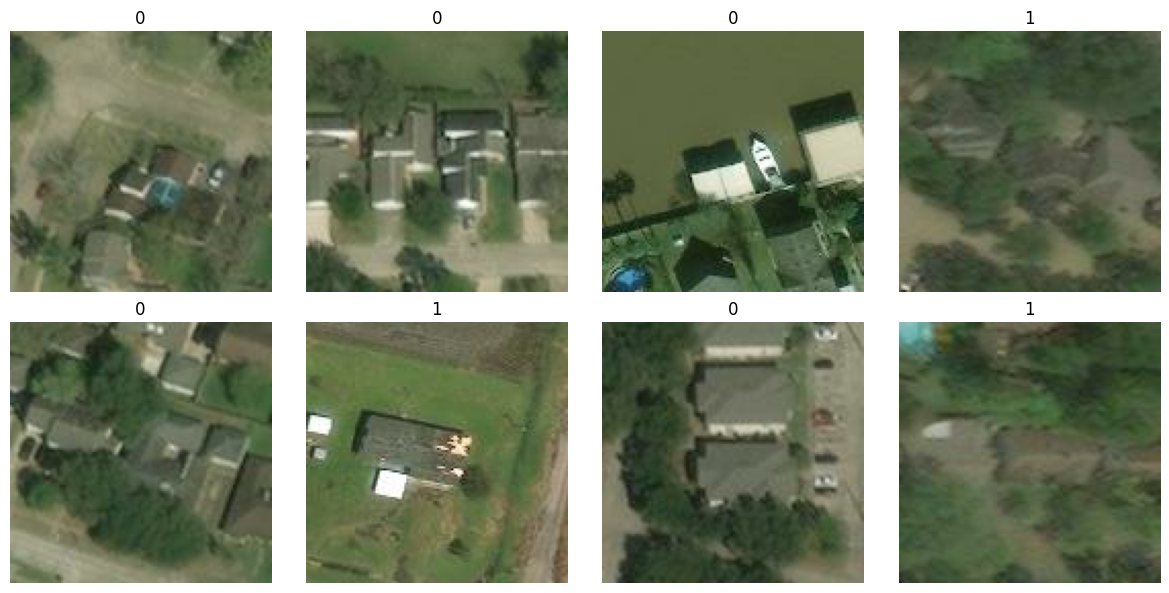

In [23]:

plt.figure(figsize=(12, 6))

for images, labels in train_ds.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

In [31]:
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                    .map(lambda image, label: (tf.image.random_contrast(image, lower=0.2, upper=1.5), label))
                        .shuffle(2000)
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

In [25]:
# Function to visaulise graphs
def plot_loss_acc(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Cross Entropy')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [26]:
# dictionary to store model results
results = dict()

# this function prints the confusion matrix and classification report on the test data
def test_conf_report(model , model_name,LR):
  test_labels1, predictions1 = eval_model_on_test_1(model)
  test_labels2, predictions2 = eval_model_on_test_2(model)
  predictions1 = np.where(predictions1 > 0.5, 1, 0)
  predictions2 = np.where(predictions2 > 0.5, 1, 0)
  cm1 = confusion_matrix(test_labels1, predictions1)
  cm2 = confusion_matrix(test_labels2, predictions2)
  print("Classification Report on Test Data 1")
  print(classification_report(test_labels1, predictions1))
  print()
  print("Confusion Matrix on Test Data 1")
  print(pd.DataFrame(cm1))

  #storing the results to a dictionary
  accuracy1 = round((cm1[0,0] + cm1[1,1]) / np.sum(cm1),3)
  accuracy2 = round((cm2[0,0] + cm2[1,1]) / np.sum(cm2),3)
  results[model_name] = [accuracy1,accuracy2,LR] 
  return results
     

In [29]:
# Baseline model
#start with a learning rate of 0.0001
model_name = "Baseline_CNN"
LR = 0.0001
epochs=100

#define a callback on the validation dataset
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=20,
                                      restore_best_weights=True,
                                      verbose=1)

In [35]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=IMG_SHAPE),
  layers.Conv2D(16, 3, padding='same', activation='relu'), 
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

#compile the model 
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

history = model.fit(
  train_ds,
  validation_data=val_ds,
  callbacks=[es], 
  epochs=epochs,
  verbose=0
)

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'experimental'